In [85]:
import asyncio
from dotenv import load_dotenv

load_dotenv()
import nest_asyncio
import aiohttp

nest_asyncio.apply()
from openai import AsyncOpenAI
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import asyncio
import tempfile
from moviepy.editor import VideoFileClip
from openai import AsyncOpenAI
from anthropic import AsyncAnthropic
import os
import datetime

In [86]:
# Load mp4 from data/headshot.mp4
def format_time(seconds):
    """Convert seconds to a time string in HH:MM:SS,MS format."""
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02},000"


async def transcribe_audio_file(client, audio_file_path):
    with open(audio_file_path, "rb") as audio_file:
        transcript_obj = await client.audio.transcriptions.create(
            model="whisper-1", file=audio_file, response_format="verbose_json"
        )
    return transcript_obj


async def transcribe_mp4(mp4_file_path):
    client = AsyncOpenAI()
    script = ""

    # Extract and convert audio to MP3
    with tempfile.NamedTemporaryFile(suffix=".mp3", delete=True) as temp_audio_file:
        video = VideoFileClip(mp4_file_path)
        video.audio.write_audiofile(temp_audio_file.name)
        temp_audio_file_path = temp_audio_file.name
        transcript_obj = await transcribe_audio_file(client, temp_audio_file_path)

    segments = transcript_obj.segments
    srt_content = ""
    for index, segment in enumerate(segments, start=1):
        # Convert start and end times from seconds to the SRT time format
        # Use the custom format_time function for start and end times
        start_time = format_time(round(segment['start']))
        end_time = format_time(round(segment['end']))

        # Append the formatted segment to the SRT content string
        srt_content += f"{index}\n{start_time} --> {end_time}\n{segment['text']}\n\n"
        script += f"{segment['text']} | start: {round(segment['start'],2)} | end: {round(segment['end'],2)}\n"

        srt_filename = "data/transcript.srt"
    with open(srt_filename, "w") as srt_file:
        srt_file.write(srt_content)

    return script


# Replace 'path/to/your/video.mp4' with the actual file path
mp4_file_path = "data/headshot.mp4"

# Run the async function
transcript = asyncio.run(transcribe_mp4(mp4_file_path))

MoviePy - Writing audio in /var/folders/9q/qp70wln55bd5fkdxdy0jw5t80000gn/T/tmpvu_o5nbs.mp3


MoviePy - Done.


In [87]:
print(transcript)

 Have you ever heard of a tri? No, not the verb try. I'm talking about the data structure called a tri, | start: 0 | end: 5
 spelled T-R-I-E. Imagine you're organizing a massive library but instead of books you're | start: 5 | end: 12
 dealing with words. A tri is like a tree of arrays that allows you to store and retrieve | start: 12 | end: 17
 these words at lightning-fast speeds. Picture each letter of the alphabet having its own shelf. | start: 17 | end: 24
 To store a word, you simply place it on the shelf corresponding to its first letter. | start: 24 | end: 28
 Then each subsequent letter gets its own subshelf branching off from the previous one. | start: 28 | end: 33
 The magic happens when you're looking for a specific word. No matter how many words are | start: 35 | end: 39
 in the library, you can find any word in the same amount of time just by following the path | start: 39 | end: 45
 created by its letters. So the next time you're typing on your phone and the keyboard see

In [88]:
text = transcript
script = """
You are given a transcript of a short video with timestamps
You are in charge of making a list of pictures that will be used to create a video
The video will be a slideshow of the pictures
The pictures should be relevant to the text
Make sure to include how long each picture should be displayed as well as the description of the picture

Example output
[{"description": "A picture of a cat", "start": 1, "end": 3}, {"description": "A picture of a dog", "start": 3, "end": 5}]
"""

In [89]:
async def generate_text(text, script):
    client = AsyncAnthropic(
        # This is the default and can be omitted
        api_key=os.environ.get("ANTHROPIC_API_KEY"),
    )

    message = await client.messages.create(
        temperature=0,
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": text + script,
            },
            {"role": "assistant", "content": "["},
        ],
        model="claude-3-opus-20240229",
    )

    return message.content

pictures = asyncio.run(generate_text(text, script))

In [90]:
pictures[0].text

'\n  {\n    "description": "An image of the word \'TRIE\' spelled out in large, colorful letters.",\n    "start": 0,\n    "end": 5\n  },\n  {\n    "description": "An illustration of a massive library with towering bookshelves filled with books.",\n    "start": 5,\n    "end": 12\n  },\n  {\n    "description": "An abstract representation of a trie data structure, with nodes and branches representing letters.",\n    "start": 12,\n    "end": 17\n  },\n  {\n    "description": "An animated sequence showing words being placed on shelves corresponding to their first letters.",\n    "start": 17,\n    "end": 24\n  },\n  {\n    "description": "A close-up shot of a word being placed on a shelf, with subsequent letters branching off into subshelves.",\n    "start": 24,\n    "end": 28\n  },\n  {\n    "description": "An illustration of subshelves branching off from each letter of a word.",\n    "start": 28,\n    "end": 33\n  },\n  {\n    "description": "A visual representation of a search query navig

In [91]:
with open("data/data.json") as f:
    data = json.load(f)

In [92]:
data['pictures'] = json.loads(f"[{pictures[0].text}")

In [93]:
data['pictures']

[{'description': "An image of the word 'TRIE' spelled out in large, colorful letters.",
  'start': 0,
  'end': 5},
 {'description': 'An illustration of a massive library with towering bookshelves filled with books.',
  'start': 5,
  'end': 12},
 {'description': 'An abstract representation of a trie data structure, with nodes and branches representing letters.',
  'start': 12,
  'end': 17},
 {'description': 'An animated sequence showing words being placed on shelves corresponding to their first letters.',
  'start': 17,
  'end': 24},
 {'description': 'A close-up shot of a word being placed on a shelf, with subsequent letters branching off into subshelves.',
  'start': 24,
  'end': 28},
 {'description': 'An illustration of subshelves branching off from each letter of a word.',
  'start': 28,
  'end': 33},
 {'description': 'A visual representation of a search query navigating through the trie structure to find a specific word.',
  'start': 35,
  'end': 39},
 {'description': 'An animation 

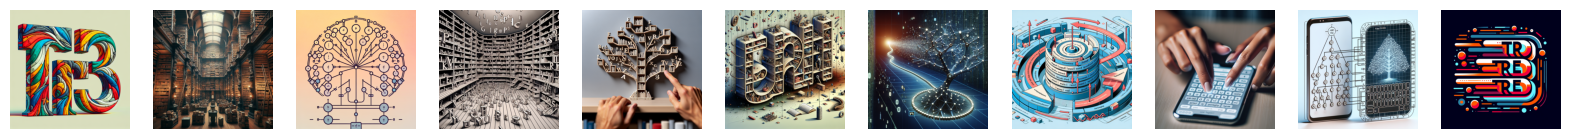

In [94]:
async def fetch_image_binary(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            # Make sure the request was successful
            if response.status == 200:
                # Read and return the binary content of the image
                return await response.read()
            else:
                # Handle possible HTTP errors (e.g., 404 Not Found) here if needed
                return None


async def generate_image(description):
    client = AsyncOpenAI()
    response = await client.images.generate(
        model="dall-e-3",
        prompt=description,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_binary = await fetch_image_binary(response.data[0].url)
    return image_binary


async def generate_images(pictures):
    tasks = [generate_image(picture['description']) for picture in pictures]
    imgs = await asyncio.gather(*tasks)
    return imgs

imgs = asyncio.run(generate_images(data['pictures']))

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, len(imgs), figsize=(20, 5))  # Adjust figsize as needed

for ax, img in zip(axes, imgs):
    image = Image.open(BytesIO(img))
    ax.imshow(image)
    ax.axis("off")  # Hide axes ticks

plt.show()

In [95]:
# Save each img in to data/images folder
for i, img in enumerate(imgs):
    with open(f"data/images/image_{i}.png", "wb") as f:
        f.write(img)
        
# save json
with open("data/data.json", "w") as f:
    json.dump(data, f)